# PID Control with Setpoint Weighting

## Setpoint 'Kick'

Our standard form for PID control has been

\begin{align}
MV & = \overline{MV} + K_P (SP - PV) + K_I\int_0^t (SP - PV)\ dt' + K_D\frac{d(SP - PV)}{dt}
\end{align}

Our initial implementation of PID control uncovered an issue with this formula  when there are sudden changes to the setpoint $SP$. The issue is most obvious in the derivative term where

\begin{align}
K_D\frac{d(SP - PV)}{dt} & \longrightarrow \infty
\end{align}

for a step change in setpoint. The issue is also evident in the proportional term $K_P (SP - PV)$ which undergoes a step change in value. In process control applications, a step change in the manipulated variable may require sudden and abrupt changes in valve position, process flows, or pressures, all of which can cause significant strain on very large devices.

This phenomenon is called **setpoint kick** (or sometimes **derivative kick**) which is generally to be avoided.

## Setpoint Weighting

The most common remedy is to introduce setpoint weighting. To this end, the PID control formula is written 

\begin{align}
MV & = \overline{MV} + K_P e_P + K_I\int_0^t e_I\ dt' + K_D\frac{de_D}{dt}
\end{align}

where the error terms are given by

\begin{align*}
e_P(t) & = \beta\ SP - PV \\
e_I(t) & = SP - PV \\
e_D(t) & = \gamma\ SP - PV
\end{align*}

The effect is to introduce a different error term for each term in the control equation. The integral term remains the same as before, which is necessary in order to force the process variable $PV$ to be equal to the setpoint $SP$ at steady-state. The error terms for the proportional and derivative terms, however, include constants $\beta$ and $\gamma$ which are used to modify the response to setpoint changes.

Common practice is to set $\gamma = 0$ which entirely eliminates derivative action based on change in the setpoint. When incorporated in PID control, this feature is sometimes called **derivative on output**. This almost always a good idea in process control because it eliminates the 'derivative kick' associated with a quick change in setpoint.

In practice, the term $\beta$ is generally tuned to meet the specific application requirements. In this case, where setpoint tracking is not a high priority, setting $\beta = 0$ is a reasonable starting point.

## Implementation of Setpoint Weighting

The implementation of setpoint weighting is straightforward. The object definition is modified to include additional parameters `beta` and `gamma` with typical default values. Error terms for the proportional and derivative terms are computed explicitly, and in the case of the derivative also saved for the next time step.

In [1]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    I = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV
        t, PV, SP = yield MV
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

## Simulation

Let's see how well this PID implementation works. We'll perform the simulation with a setpoint that starts at room temperature, then rises to 50°C at $t = 50$ seconds. The data historian will record values of the setpoint, process variable, computed manipulated variable, and the actual value of the manipulated variable.

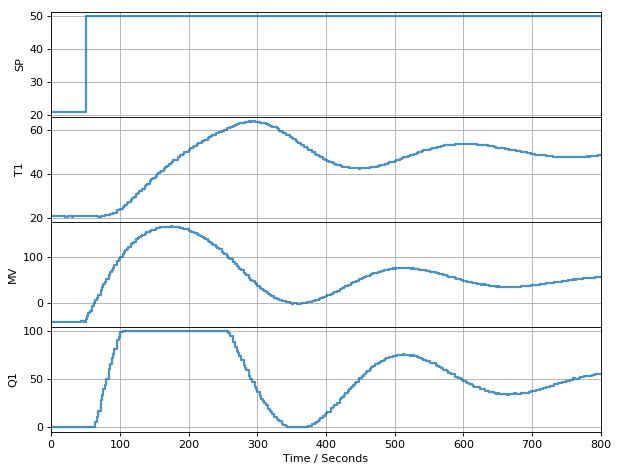

TCLab Model disconnected successfully.


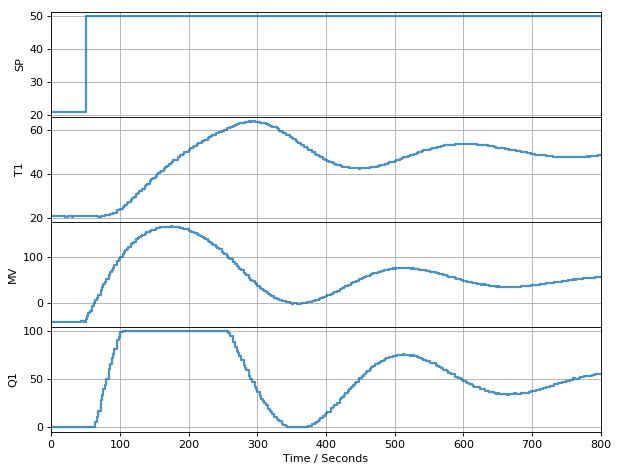

In [2]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 800

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = T1 if t < 50 else 50           # get setpoint
        PV = lab.T1                         # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.U1 = MV                         # apply 
        p.update(t)                         # update information display